# Generating Correlated Spike Trains

## Multivariate Poisson Distribuiton

(Based on [[Kawamura]](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiz8J30n_7-AhXdJUQIHXOWBpcQFnoECBYQAQ&url=https%3A%2F%2Fprojecteuclid.org%2Fjournals%2Fkodai-mathematical-journal%2Fvolume-2%2Fissue-3%2FThe-structure-of-multivariate-Poisson-distribution%2F10.2996%2Fkmj%2F1138036064.pdf&usg=AOvVaw1jZx430evqMSPJVQCIg2Dc), [[Karlis]](http://www2.stat-athens.aueb.gr/~karlis/multivariate%20Poisson%20models.pdf) and [[Wolfram]](https://reference.wolfram.com/language/ref/MultivariatePoissonDistribution.html#:~:text=The%20multivariate%20Poisson%20distribution%20corresponds,Mean%2C%20CDF%2C%20and%20RandomVariate.))

**Def.** Multivariate Poisson Distribution.

Let $X_0$, $\ldots$, $X_N$ be independent random variables with $X_i \sim \text{pois}(\lambda_i)$. Consider random variables $Y_1 = X_0 + X_1$, $Y_2 = X_0 + X_2$, $\ldots$, $Y_N = X_0 + X_N$. Then the vector $Y = (Y_1, \ldots, Y_N)$ has multivariate poisson distribution.

Properties:
1. By properties of Poisson distribution, each $Y_i \sim \text{pois}(\lambda_0 + \lambda_i) \equiv \text{pois}(\lambda_{y_i})$. Thus, $E(Y_i) = \text{Var}(Y_i) = \lambda_0 + \lambda_i$.
2. We can show that $\text{Cov}(Y_i, Y_j) = \lambda_0$.
3. From 1, $E(Y) = [\lambda_0 + \lambda_1, \lambda_0 + \lambda_2, \ldots, \lambda_0 + \lambda_N]$.
4. From 1 and 2,
$$
\text{Var}(Y) = \begin{bmatrix}
\lambda_0 + \lambda_1 & \lambda_0 & \ldots & \lambda_0 \\
\lambda_0 & \lambda_0 + \lambda_2 & \ldots & \lambda_0 \\
\vdots & \vdots & \vdots & \vdots \\
\lambda_0 & \lambda_0 & \ldots & \lambda_0 + \lambda_N
\end{bmatrix}
$$

In our case $\lambda_0$ is a firing rate of each cell which is sampled from truncated normal or levy distribution (based on data).

## MVP with Correlated Variables

If $X_0$, $\ldots$, $X_N$ are not independent, covariance function becomes more complex. 

- In sinusoidal modulation, it is assumed that $X_0 \sim \text{pois}(\lambda_0)$, $X_t \sim \text{pois}(\lambda_0\sin t)$. By properties of Poisson distribution, $X_t$ can be expressed as a product of two independent Poisson variables, $X_0$ and $m_t \sim \text{pois}(\sin t)$.
    We can show that
    $$
    \text{Cov}(X_0, X_t) = \lambda_0 \sin(t)
    $$ 
    and
    $$
    \text{Cov}(X_t, X_{t+1}) = \lambda_0 \sin(t)\sin(t+1),
    $$
    i.e., $X_i$ themselves are correlated. Autocovariance function of $Y$-s becomes
    $$
    \text{Cov}(Y_t, Y_{t+k}) = \lambda_0(1 + \sin(t) + \sin(t+k) + \sin(t)\sin(t+k)).
    $$

- In pink-noise modulation, it is assumed that $X_0 \sim \text{pois}(0)$, $X_t \sim \text{pois}(\lambda_0\varepsilon_t)$ where $\varepsilon_t \sim pn$.

In [107]:
from scipy.stats import truncnorm
from scipy.signal import lfilter, welch

import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq

The function below generates pink noise.

In [108]:
## TODO: Author / Source ??

def minmax(x):
    """min max normalizes the given array"""
    return (x - np.min(x))/(np.max(x)-np.min(x))

def make_pink_noise(num_traces=100,num_samples=4999):
    """
    Modulates a generated gausian white noise trace to create pink noise.
    
    Parameters
    ----------
    num_traces : int, optional
        number of noise traces to create (first dimension), by default 100
    num_samples : int, optional
        length of the trace (second dimension), by default 4999
    Returns
    -------
    np.array
        noise trace
    """    

    # Pink noise or ``1/f noise'' is an interesting case because there is no exact (rational, finite-order) filter which can produce it from white noise. 
    # This is because the ideal amplitude response of the filter must be proportional to the irrational function  1 / sqrt(f) , where f denotes frequency in Hz.
    # However, it is easy enough to generate pink noise to any desired degree of approximation

    #The following code generates pretty good pink noise:

    B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]  #The coefficient A, B determines a filter that converts white noise to 1/f spectrum. 
    A = [1, -2.494956002,   2.017265875,  -0.522189400]         #You can use this function to check the frequency response of the filter, which should give you a 1/f amplitude response.

    invfn = np.zeros((num_traces,num_samples))
    for i in np.arange(0,num_traces):
        wn = np.random.normal(loc=1, scale=0.5, size=num_samples+2000)      # Generate Gausian white noise 
        invfn[i,:] = wn[2000:]
        invfn[i,:] = minmax(lfilter(B, A, wn)[2000:])+0.5                # Filtering white noise to create a close approximation of '1/f' Noise
                                                                            # The filtered signal is pink noise with 0 mean. 
                                                                            # The minmax function normalizes the signal to have values between [0,1].
                                                                            # Adding 0.5 to it makes it positive and have mean 1, since firing rate cannot be negative
    return invfn

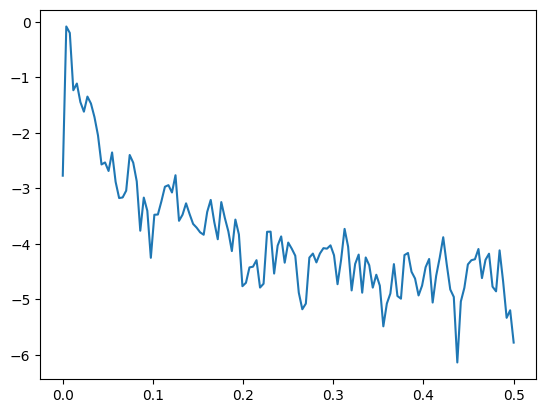

In [109]:
noise = make_pink_noise(1, 1000)
from scipy.signal import welch

psd = welch(noise)

plt.plot(psd[0], np.log(psd[1][0]))

The function below samples $\lambda_0$-s from truncated normal distribution.

In [20]:
def sample_from_trunc_norm(mean, std, size = 1):
    '''
    Generates (size, ) independent samples from a TN distribution parameterized by mean and std.

    Parameters:
    ----------
    mean: float
        Mean of TN.

    std: float
        Std of TN.

    size: int
        Number of samples

    Returns:
    ----------
    samples: ndarray(shape = (size, ))
        Generated samples.
    '''
    # Compute end points for the trunc norm
    a = (0 - mean) / std
    b = (100 - mean) / std 
    print(f'Bounds: [{a}, {b}]')

    return truncnorm.rvs(a = a, b = b, loc = mean, scale = std, size = size)

In [21]:
# Setting up mock population of 3 presynaptic neurons
mean_fr = 10 # Mean firing rate
std_fr = 2 # Std firing rate

sample_from_trunc_norm(mean_fr, std_fr, size = 3)

Bounds: [-5.0, 45.0]


array([10.97252817, 11.94202669,  7.74182497])

The function below builds the sequence of lambdas for $Y$-s for each cell.

In [103]:
def build_lambda_y(n_cells, t_stop, f, depth_of_mod):
  '''
  Builds a sequence \lambda_0, \lambda_0 + \lambda_1, ..., \lambda_0 + \lambda_N.

  Parameters:
  ----------
  n_cells: int
    Number of cells.

  t_stop: int
    Length of time sequence.

  f: float
    Frequency of oscillations.

  depth_of_mod: float
    Modulation depth. Float in range [0, 1].
  '''

  # Sample firing rates (lambda_0)
  mean_fr = 10 # Mean firing rate
  std_fr = 2 # Std firing rate
  firing_rates = sample_from_trunc_norm(mean_fr, std_fr, size = n_cells) # lambda_0 for each cell

  # Time
  t = np.arange(0, t_stop, 0.001)

  # Placeholder for modulated traces for each cell
  lambdas_of_y = np.zeros((n_cells, len(t)))

  # Phase of a sine wave
  P = 0

  # Generate pink noise
  noise = make_pink_noise(n_cells, len(t))

  for i in range(n_cells):

    lambda_0 = firing_rates[i]
    # depth_of_mod = 0 (no modulation)   -->  mod_trace = offset 
    # depth_of_mod = 1 (full modulation) -->  mod_trace = offset + (offset * (np.sin((2 * np.pi * f * t ) + P)))

    # Sinusoidal modulation
    # lambda_i =  lambda_0 + lambda_0 * depth_of_mod * np.sin((2 * np.pi * f * t ) + P)

    # Pink noise modulation
    lambda_i =  lambda_0 * noise[i]

    lambdas_of_y[i, :] = lambda_i

  return lambdas_of_y

Bounds: [-5.0, 45.0]
9.600724734641043


array([[18.17642135, 17.91067312, 18.22282319, ..., 21.26937883,
        20.91950348, 19.39625969],
       [16.03320083, 16.81352789, 17.11692257, ..., 16.13455619,
        16.94831869, 17.47292029]])

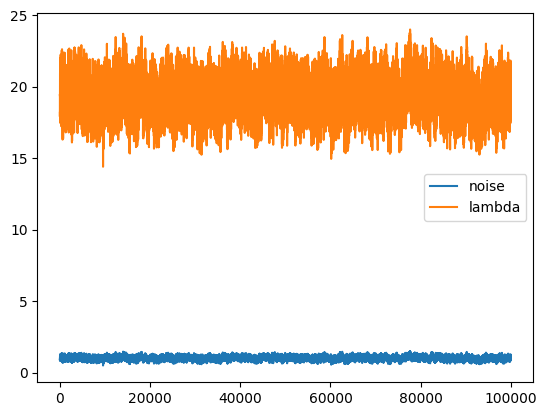

In [71]:
build_lambda_y(2, 100, 1, 1)

Finaly, the function below samples a sequence $Y_1 \sim \text{pois}(\lambda_{y_1})$, $\ldots$, $Y_N \sim \text{pois}(\lambda_{y_N})$ and combines it into a vector $Y = [Y_1, \ldots, Y_N]$. Based on [[Heeger]](https://www.cns.nyu.edu/~david/handouts/poisson.pdf), if each $\lambda_{y_i}$ is adjusted appropriatly, we can simulate a binary train by comparing each $Y_i$ with $0$.

In [46]:
def sample_spike_train(lambdas_of_y):
  '''
  The Poisson distribution is a discrete probability distribution that expresses the probability of a 
  given number of events occurring in a fixed interval of time or space if these events occur with a 
  known constant mean rate and independently of the time since the last event.  

  An unmodulated cell has a constant mean firing rate, but as modulation causes the firing rate to
  change over time (phase) we consider each small time interval (as determined by length of the timestep) 
  where the firing rate is constant.

  For a given cell i and a given timestep t we model how many times cell i fires during timestep t
  using the poisson distribution with λ being set to the firing rate for cell i at time t (adjusted 
  to be the firing rate per milisecond, i.e. per timstep).

  For a given cell this results in many timesteps that do not have spikes - but apoximatly 10 spikes every 1000 timesteps.

  Parameters:
  ----------
  lambdas_of_y: ndarray(shape = (n_cells, T))
    lambdas for each y_i for each cell.

  Returns:
  ----------
  spikes: list[ndarray]
    Timestamps of spikes for each cell.
  '''

  n_cells, _ = lambdas_of_y.shape

  # Timestamps of spikes
  spikes = []

  for i in range(n_cells):

    lambda_y = lambdas_of_y[i, :]

    # Can't have negative firing rates
    lambda_y[lambda_y < 0] = 0 

    # Sample Y
    y = np.random.poisson(lambda_y / 1000)

    spikes.append(np.where(y > 0)[0]) 

  return spikes

In [47]:
sample_spike_train(build_lambda_y(2, 100, 1, 1))[0][:10]

Bounds: [-5.0, 45.0]


array([ 51,  69,  89, 207, 217, 285, 326, 335, 442, 460])

The function below plots simulation results for the sinusoidal modulation.

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (30, 15))

t_stop = 0.1 # Seconds
n_cells = 1000 
f = 64 # Frequency of oscillation (Gamma inhibition)

dmods = [0, 0.5, 1]

for i, depth in enumerate(dmods):
    lambda_y = build_lambda_y(n_cells, t_stop, f, depth)
    for j in range(4):
        ax[i, 0].plot(lambda_y[j, :], label = f"Cell {j}")
    ax[i, 0].set_xlabel("Time (ms)")
    ax[i, 0].set_ylabel("Fir. rate (lam_0 + lam_i)")
    ax[i, 0].set_title(f"Mod: {depth}")
    ax[i, 0].legend()

    spike_inds = sample_spike_train(lambda_y)
    for j in range(len(spike_inds)):
        ax[i, 1].scatter(spike_inds[j], np.ones(len(spike_inds[j])) * j, c = 'salmon', alpha = 0.4)

    t = np.arange(0, t_stop, 0.001)
    ax[i, 1].plot(100 * depth *np.sin(2 * np.pi * f * t) + 500)
    ax[i, 1].set_xlabel("Time (ms)")
    ax[i, 1].set_ylabel("Node ID")
    ax[i, 1].set_title(f"Mod: {depth}")

## Stuff from class

Generate and sum 10 spike trains

In [105]:
tr = []

for _ in range(10):
    spike_inds = sample_spike_train(build_lambda_y(1, 100, 60, 1))

    train = np.arange(0, 100, 0.001) * 0
    train[spike_inds] = 1
    tr.append(train)

Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]
Bounds: [-5.0, 45.0]


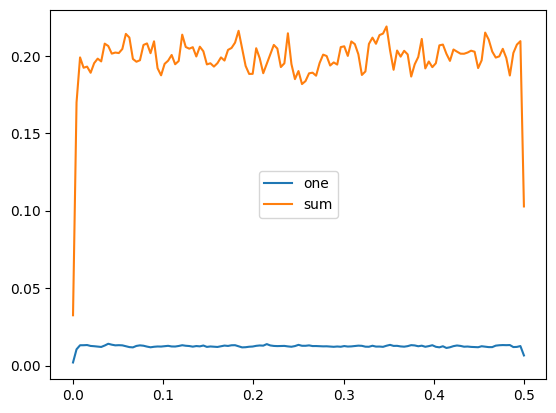

In [106]:
tr_array = np.array(tr)
summed = tr_array.sum(axis = 0)
psd0 = welch(tr_array[0])
psd1 = welch(summed)

plt.plot(psd0[0], psd0[1], label = "one")
plt.plot(psd1[0], psd1[1], label = "sum")
plt.legend()

(array([0.03656278, 0.03207848, 0.01680692, 0.01620559, 0.01674806,
        0.01828627, 0.01827368, 0.01761726, 0.0172299 , 0.01840574,
        0.01750794, 0.01788929, 0.01789411, 0.01806832, 0.01701485,
        0.01735456, 0.01747649, 0.01774072, 0.01752684, 0.01599168,
        0.01715412, 0.01758323, 0.01681117, 0.01766914, 0.0182903 ,
        0.01885264, 0.01857398, 0.01838105, 0.0173447 , 0.0173792 ,
        0.01678902, 0.01718778, 0.0172458 , 0.019892  , 0.01850172,
        0.01702899, 0.01711388, 0.01681905, 0.01831571, 0.01894361,
        0.0183926 , 0.01685264, 0.01777761, 0.01739326, 0.0170494 ,
        0.01731058, 0.01751513, 0.01708745, 0.01706486, 0.01884342,
        0.01839347, 0.01635036, 0.01648398, 0.01708391, 0.01856551,
        0.01778252, 0.0178161 , 0.0189342 , 0.01852249, 0.01783491,
        0.01746942, 0.01654696, 0.01569521, 0.01627631, 0.01755714,
        0.01894699, 0.01942998, 0.0195205 , 0.01949143, 0.01804956,
        0.0194341 , 0.01852576, 0.01758092, 0.01

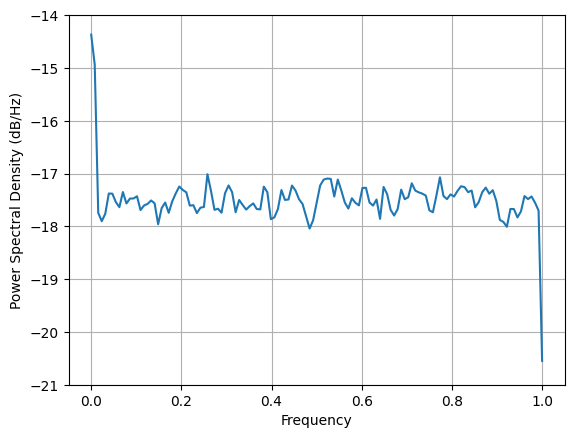

In [87]:
plt.psd(tr_array[0])

Plot a train

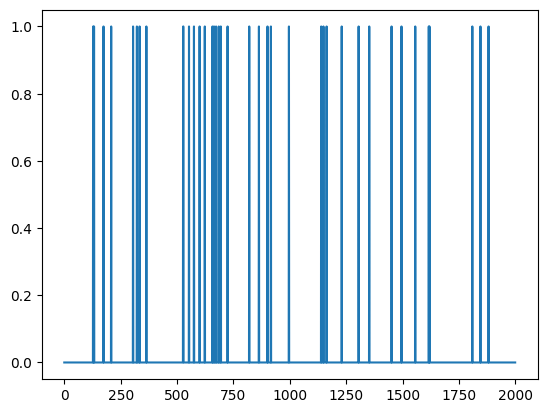

In [80]:
plt.plot(train[:2000])

In [110]:
build_lambda_y(1, 100, 60, 1).shape

Bounds: [-5.0, 45.0]


(1, 100000)

Bounds: [-5.0, 45.0]


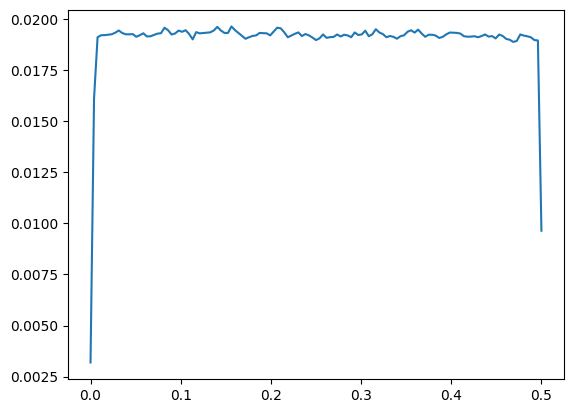

In [104]:
# Check PSD
np.random.seed(125)
spike_inds = sample_spike_train(build_lambda_y(1, 3000, 60, 1))

train = np.arange(0, 3000, 0.001) * 0
train[spike_inds] = 1

psd = welch(train)

#plt.psd(train, Fs = 1000);
plt.plot(psd[0], psd[1])